In [1]:
import pandas as pd
import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re 
import keras

In [2]:
# !python -m spacy download en_core_web_md

In [3]:
nlp = spacy.load('en_core_web_md')

In [4]:
from os import truncate
train = pd.read_csv("/content/train.csv" )
# test = pd.read_csv("/content/test.csv")
# val = pd.read_csv("/content/validation.csv")

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them 
tags = r"@\w*"


def preprocess_text(sentence, stem = True):
    sentence = tokenizer.tokenize(sentence)
    # sentence = sentence.split()

    # sentence = [re.sub(tags, "", sentence)]
    

    text = []
    # print(sentence)
    for word in sentence:
        word = word.lstrip()
        word = word.rstrip()
        word = word.replace(' ','')
        if word not in stopwords:
            
            if stem:
                text.append(stemmer.stem(word).lower())
            else:
                text.append(word.lower())
                
    return tokenizer.tokenize(" ".join(text))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
print(f"Orignal Text : {train.review[11]}")
print()
print(f"Preprocessed Text : {preprocess_text(train.review[11])}")

Orignal Text : Very disappointed to know that Zoom virtual background is not supporting tablet

Preprocessed Text : ['veri', 'disappoint', 'know', 'zoom', 'virtual', 'background', 'support', 'tablet']


In [8]:
train.review = train.review .map(preprocess_text)
train.head()

,review,sentiment
0,"[aditya, ingol, deaf]",2
1,"[i, love, app, there, issu, u, could, add, fea...",1
2,"[so, hard, use, the, web, app, fail, mobil, ap...",0
3,"[i, hate, app, make, sound, everi, time, someo...",1
4,"[useless, bse, star, mf, meet, voic, mych, slo...",0


In [9]:
# vocabulary of words present in dataset
data_vocab = []
for text in train.review :
    for word in text:
        if word not in data_vocab:
            data_vocab.append(word)

In [10]:
len(data_vocab)

12785

In [11]:
train.review =train.review .apply(lambda x: " ".join(x) )
# # x_test[text]=x_test[text].apply(lambda x: " ".join(x) )

In [12]:
train.head(2)

,review,sentiment
0,aditya ingol deaf,2
1,i love app there issu u could add featur spotl...,1


In [13]:
print(train.sentiment.value_counts())
# print(test.sentiment.value_counts())

2    13772
0    12119
1    10575
Name: sentiment, dtype: int64


In [14]:
len(train)

36466

In [15]:
# len(test)

In [16]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
     
        longest_input = max(longest_input, text_len)
    return longest_input


In [17]:
longest_input = get_longest_text(train['review'])
longest_input

271

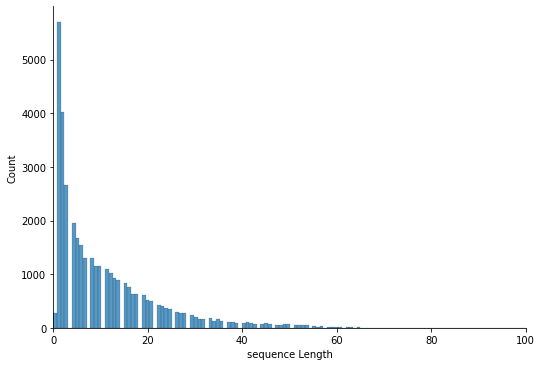

In [18]:
import seaborn as sns
seq_len = [len(i.split()) for i in train.review]
ax = sns.displot(seq_len, height=5, aspect=1.5);
ax.set_xlabels('sequence Length');
ax.set(xlim=(0,100));

In [19]:
def auto_truncate(val):
    return val[:80]


In [20]:
train.review = train.review .map(auto_truncate)
train.head(2)

,review,sentiment
0,aditya ingol deaf,2
1,i love app there issu u could add featur spotl...,1


In [21]:
longest_input = get_longest_text(train['review'])
longest_input

40

In [22]:
data_emb = np.zeros((len(train), longest_input, 300))
for i, text in enumerate(tqdm(nlp.pipe(train['review']), total=len(train))):
    for j, token in enumerate(text):
        data_emb[i, j] = token.vector

  0%|          | 0/36466 [00:00<?, ?it/s]

In [23]:
# prepare y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(train['sentiment'])
y_encoded = to_categorical(y_encoded)

In [24]:
y_encoded[:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [49]:
from IPython.display import Image

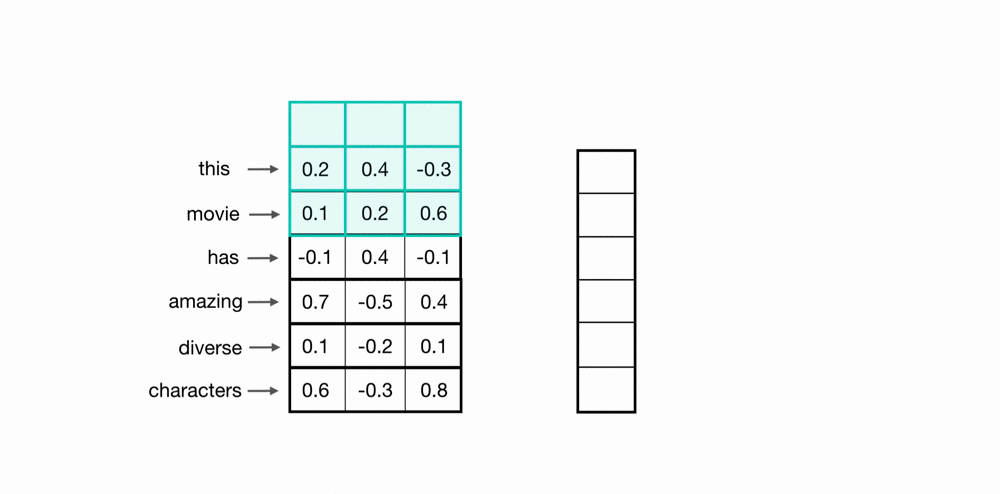

In [50]:
Image(open('/content/ab0d.gif','rb').read())

In [26]:
import tensorflow as tf
# define the network
inputs = tf.keras.layers.Input((longest_input, 300))
reshaped = tf.keras.layers.Reshape((longest_input, 300, 1))(inputs)
filters = [2, 3, 4 , 5 , 6]
# define the conv net
conv_1 = tf.keras.layers.Conv2D(100, (filters[0], 300), activation='relu')(reshaped)
conv_2 = tf.keras.layers.Conv2D(100, (filters[1], 300), activation='relu')(reshaped)
conv_3 = tf.keras.layers.Conv2D(100, (filters[2], 300), activation='relu')(reshaped)
conv_4 = tf.keras.layers.Conv2D(100, (filters[3], 300), activation='relu')(reshaped)
conv_5 = tf.keras.layers.Conv2D(100, (filters[4], 300), activation='relu')(reshaped)
# define max-pooling
pool_1 = tf.keras.layers.MaxPooling2D((longest_input - filters[0] + 1, 1), strides=(1,1))(conv_1)
pool_2 = tf.keras.layers.MaxPooling2D((longest_input - filters[1] + 1, 1), strides=(1,1))(conv_2)
pool_3 = tf.keras.layers.MaxPooling2D((longest_input - filters[2] + 1, 1), strides=(1,1))(conv_3)
pool_4 = tf.keras.layers.MaxPooling2D((longest_input - filters[3] + 1, 1), strides=(1,1))(conv_4)
pool_5 = tf.keras.layers.MaxPooling2D((longest_input - filters[4] + 1, 1), strides=(1,1))(conv_5)
# concatenate the convs
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2, pool_3], axis=1)
# define max-pooling

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(merged_tensor)

# add a dense layer

clf = tf.keras.layers.Dense(100, activation='relu')(flatten)
clf = tf.keras.layers.Dropout(0.3)(clf)

clf = tf.keras.layers.Dense(60, activation='relu')(clf)
clf = tf.keras.layers.Dropout(0.3)(clf)

clf = tf.keras.layers.Dense(20, activation='relu')(clf)
clf = tf.keras.layers.Dropout(0.3)(clf)

clf = tf.keras.layers.Dense(10, activation='relu')(clf)
clf = tf.keras.layers.Dropout(0.3)(clf)
# add final output
clf = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(clf)

In [27]:
# model = Sequential()
# 	model.add(Dropout(0.2, input_shape=(60,)))
# 	model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
# 	model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
# 	model.add(Dense(1, activation='sigmoid'))

In [28]:
# compile the model
model = tf.keras.models.Model(inputs, clf )

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 300)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 40, 300, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 39, 1, 100)   60100       ['reshape_1[0][0]']              
                                                                                                  
 conv2d_6 (Conv2D)              (None, 38, 1, 100)   90100       ['reshape_1[0][0]']              
                                                                                              

In [29]:
!pip install pydot graphviz

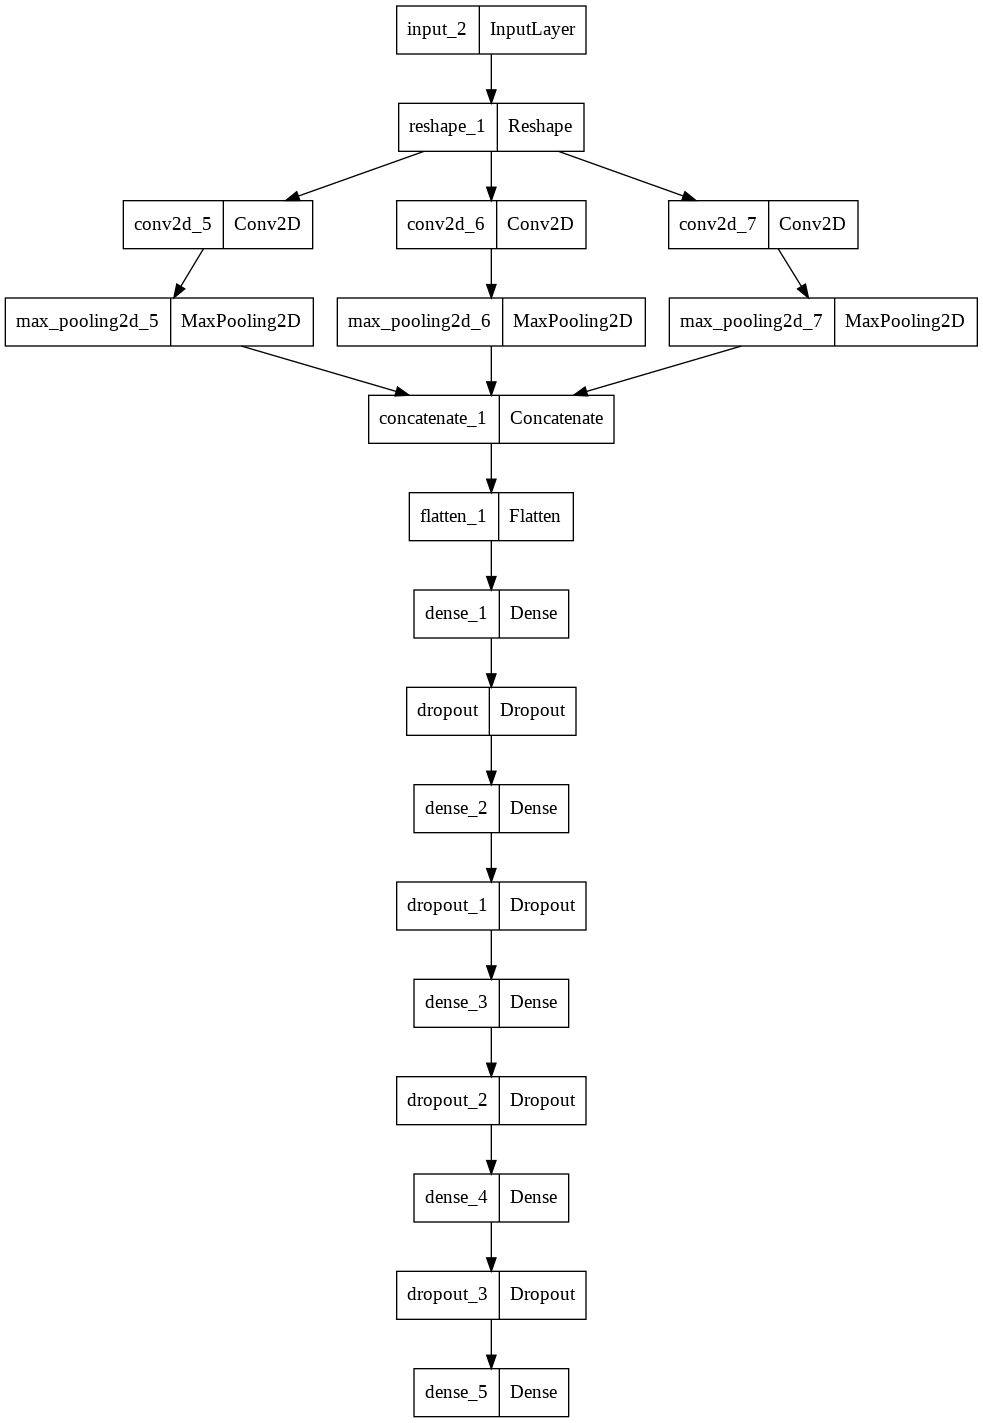

In [30]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_emb, y_encoded, test_size=.1)

In [32]:
# Creat checkpoint to save model at the end of each epoch:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

# Creat EarlyStopping checkpoint:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(x_train, y_train, epochs=30 ,validation_split=5/60 , callbacks=[checkpoint_cb, early_stopping_cb], batch_size =32)

Epoch 1/30
941/941 [==============================] - 54s 47ms/step - loss: 1.0069 - acc: 0.4879 - val_loss: 0.9228 - val_acc: 0.5675
Epoch 2/30
941/941 [==============================] - 44s 47ms/step - loss: 0.9287 - acc: 0.5561 - val_loss: 0.8889 - val_acc: 0.5740
Epoch 3/30
941/941 [==============================] - 44s 47ms/step - loss: 0.8874 - acc: 0.5797 - val_loss: 0.8841 - val_acc: 0.5788
Epoch 4/30
941/941 [==============================] - 44s 47ms/step - loss: 0.8510 - acc: 0.5957 - val_loss: 0.8737 - val_acc: 0.5982
Epoch 5/30
941/941 [==============================] - 44s 46ms/step - loss: 0.8106 - acc: 0.6220 - val_loss: 0.8621 - val_acc: 0.6040
Epoch 6/30
941/941 [==============================] - 44s 47ms/step - loss: 0.7666 - acc: 0.6461 - val_loss: 0.8959 - val_acc: 0.6011
Epoch 7/30
941/941 [==============================] - 43s 46ms/step - loss: 0.7337 - acc: 0.6606 - val_loss: 0.8805 - val_acc: 0.6095
Epoch 8/30
941/941 [==============================] - 43s 46ms

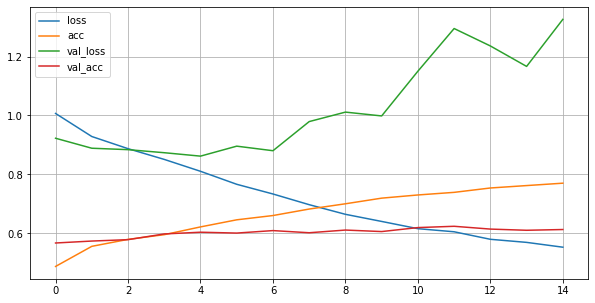

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

learning_data = pd.DataFrame(history.history)
# learning_data.head()
learning_data.plot(figsize=(10,5))
plt.grid(True)
plt.show()

In [34]:
model.evaluate(x_test, y_test)

114/114 [==============================] - 3s 25ms/step - loss: 0.8612 - acc: 0.5969


[0.8611935973167419, 0.5969289541244507]

In [35]:
encoder.classes_[2]

2

In [36]:
text = "Hello do you have python courses?"
text_v = np.zeros((1, longest_input, 300))
for i, token in enumerate(nlp(text)):
    if i>=longest_input:
        break
    text_v[0, i] = token.vector
predictions = model.predict(text_v)
predictions

array([[0.41184366, 0.39445838, 0.19369796]], dtype=float32)

In [37]:
np.argmax(predictions)

0

In [38]:
for label, prob in zip(encoder.classes_, predictions[0]):
    print((label, round(prob, 3)))

(0, 0.412)
(1, 0.394)
(2, 0.194)


In [39]:
def predict_n_gram(text):
    text_v = np.zeros((1, longest_input, 300))
    for i, token in enumerate(nlp(text)):
        if i>=longest_input:
            break
        text_v[0, i] = token.vector
    # predict the input 
    prediction = model.predict(text_v)
    label = encoder.classes_[np.argmax(prediction)]
    return label

In [40]:
predict_n_gram("it was excellent")

2